# *Credit Card Fraud Detection - Task 2 & Task 3*

![logo](images/logo.jpg)

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

data = pd.read_csv("data/data.csv")

def contextualize(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Modelação Preditiva

### Seleção de Técnicas de Modelação

Tomando em consideração os objetivos de mineração de dados, em particular o problema de classificação a tratar, optam-se pelas seguintes técnicas de modelação:
1. ***K-Nearest Neighbors*** - classifica novos dados através da sua proximidade com os dados já existentes, tendo em consideração as classes dos *k* vizinhos mais próximos
2. ***Naive Bayes*** - baseia-se no Teorema de Bayes e no conceito de probabilidade condicionada para efetuar a classificação
3. ***Decision Tree*** - toma decisões a partir dos atributos de cada cliente, dividindo sucessivamente o conjunto inicial em subconjuntos de menor dimensão
4. ***Bagging*** - obtém um conjunto de modelos usando diferentes amostras do conjunto de treino
5. ***Random Forest*** - combina as previsões de várias árvores de decisão
6. ***AdaBoost*** - cria uma sequência de classificadores simples e ajusta iterativamente o peso de cada instância mal classificada
7. ***Gradient Boosting*** - cria uma sequência de classificadores simples em que cada um tenta corrigir os erros do anterior
8. ***Support Vector Machine*** - procura o hiper-plano que melhor separa os registos das diferentes classes, maximizando a margem
9. ***Neural Network*** - aprende padrões complexos nos dados através de camadas de "neurónios" artificiais
10. ***Voting*** - combina as previsões de vários modelos diferentes

O número elevado de diferentes técnicas a experimentar prende-se com o facto de, desconhecendo-se a estrutura/organização subjacente aos dados, procurar-se qual o modelo que melhor se adapta aos mesmos e que produz os melhores resultados.

### Geração do *Design* do Teste

Todos os modelos devem ser treinados com um conjunto de dados de treino e testados num conjunto de dados de teste. Assim, é necessário dividir o o conjunto de dados nestes dois subconjuntos, de forma aleatória.

In [2]:
predictors = data.drop('is_fraud', axis = 1)

targets = data['is_fraud']

(train_predictors, test_predictors, train_targets, test_targets) = train_test_split(predictors, targets, test_size = 0.25, random_state = 10)

A variável `predictors` contém as variáveis preditivas e os respetivos valores, enquanto a variável `targets` contém os valores correspondentes da variável-avo.

A função `train_test_split` separa os dados em conjuntos de treino e de teste, de modo que o conjunto de teste contenha 25% dos dados originais.

Para cada técnica de modelação, o processo será o seguinte:
1. Tendo em conta que o conjunto de dados é desequilibrado, recorrer-se-á à técnica de *Synthetic Minority Over-Sampling* (SMOTE), que cria novos exemplos sintéticos da classe minoritária (transações fraudulentas), reduzindo os riscos de *undersampling* e de *oversampling*;
2. A par disso, para uniformizar as amplitudes das escalas dos diferentes atributos numéricos e evitar que os atributos de maior magnitude absorvam/dominem os atributos de menor magnitude, far-se-á *Standardization*;
3. Finalmente, para melhorar os resultados obtidos no processo de afinação de hiper-parâmetros de cada modelo e para evitar flutuações dos resultados de avaliação devidos à divisão aleatória dos dados em conjuntos de treino e de teste, recorrer-se-á a *cross-validation*. Assim, dividir-se-ão os dados em *k* subconjuntos e usar-se-á um dos subconjuntos como conjunto de teste e os restantes conjuntos como conjunto de treino, repetindo este processo *k* vezes, mas garantindo que cada subconjunto só é considerado conjunto de teste uma única vez. Neste caso, considera-se *k* = 10 e realiza-se *stratified cross-validation*, de modo que a proporção da variável-alvo se mantenha constante em cada um dos subconjuntos gerados.

In [ ]:
def hyperparameter_tuning(pipeline, parameter_grid, name):
    pipeline.fit(train_predictors, train_targets)
    probabilities = pipeline.predict_proba(test_predictors)[:, 1]
    auc = roc_auc_score(test_targets, probabilities)
    print(name, '- AUC Pré-Afinação: {:.2f}'.format(auc))

    cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)
    model = GridSearchCV(pipeline, parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

    model.fit(train_predictors, train_targets)
    auc = model.score(test_predictors, test_targets)
    
    print(name, '- Melhores Parâmetros:', model.best_params_)
    print(name, '- AUC Pós-Afinação: {:.2f}'.format(auc))

    return model

O critério primordial de avaliação dos modelos será a área abaixo da curva *Receiver Operating Characteristic* (ROC) - *Area Under Curve* (AUC) -  entre a probabilidade prevista e o valor real da variável-avo. Assim, avaliar-se-á cada modelo quanto à sua capacidade de distinguir corretamente transações fraudulentas de legítimas.

In [ ]:
def plot_roc_curve(model, name):
    probabilities = model.predict_proba(test_predictors)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_targets, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (5, 5))
    plt.plot(fpr, tpr, label = f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Classificador Aleatório')
    contextualize(name + ' - Curva ROC', 'Rácio de Falsos Positivos (FPR)', 'Rácio de Verdadeiros Positivos (TPR)')
    plt.legend(loc = 'lower right')
    plt.show()

    return roc_auc


Para além disso, serão calculadas as restantes métricas de avaliação (exatidão, precisão e *recall*), bem como visualizada a matriz de confusão, tendo em vista uma comparação completa e adequadamente fundamentada dos modelos.

In [ ]:
def plot_confusion_matrix(model, name):
    predictions = model.predict(test_predictors)
    print(classification_report(test_targets, predictions))

    ConfusionMatrixDisplay(confusion_matrix(test_targets, predictions)).plot()
    contextualize(name + ' - Matriz de Confusão', 'Classe Prevista', 'Classe Real')
    plt.show()

### Construção dos Modelos

#### *K-Nearest Neighbors*

In [ ]:
knn_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

knn_parameter_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_name = 'K-Nearest Neighbors'

knn = hyperparameter_tuning(knn_pipeline, knn_parameter_grid, knn_name)

K-Nearest Neighbors - AUC Pré-Afinação: 0.55
K-Nearest Neighbors - Melhores Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
K-Nearest Neighbors - AUC Pós-Afinação: 0.57


O algoritmo *K-Nearest Neighbors* - sem qualquer afinação de hiper-parâmetros - obtém uma AUC de 0.55 a classificar os dados de teste. Depois de afinar os hiper-parâmetros, a AUC obtida melhora ligeiramente, para 0.57. O algoritmo executa em cerca de 1 minuto.

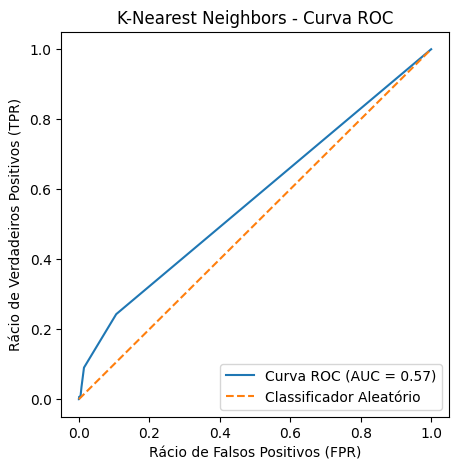

In [ ]:
knn_auc = plot_roc_curve(knn, knn_name)

Visualmente, evidencia-se que este desempenho do *K-Nearest Neighbors* nos dados de treino é ligeiramente melhor do que um classificador aleatório, em termos de AUC.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7199
           1       0.03      0.01      0.01       144

    accuracy                           0.98      7343
   macro avg       0.51      0.50      0.50      7343
weighted avg       0.96      0.98      0.97      7343



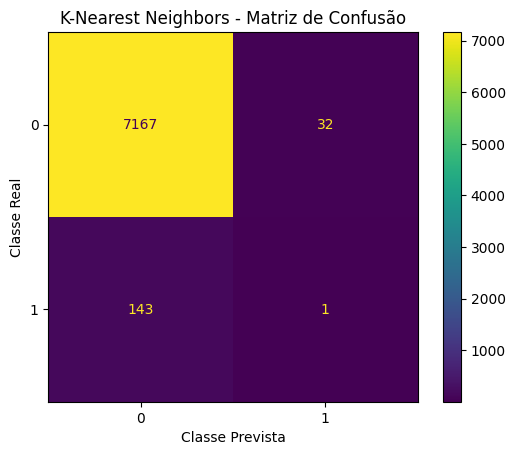

In [ ]:
plot_confusion_matrix(knn, knn_name)

Observando a matriz de confusão, percebe-se que este modelo só classificou corretamente uma transação como fraudulenta, tendo uma forte tendência para classificar como legítimas transações que não o são. Por isso, o modelo *K-Nearest Neighbors* obtém (para a classe positiva) valores de precisão de 3% e *recall* de 1%, sendo estes resultados extremamente baixos. O valor obtido para a exatidão (98%) não tem relevância, dado que o conjunto de dados é extremamente desequilibrado, com uma prevalência muito maior de transações legítimas, pelo que classificar todas as transações como legítimas resultaria sempre numa exatidão de 98%, não estando este modelo muito distante disso mesmo.

#### *Naive Bayes*

In [ ]:
naive_bayes_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

naive_bayes_parameter_grid = {
    'classifier__var_smoothing': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

naive_bayes_name = 'Naive Bayes'

naive_bayes = hyperparameter_tuning(naive_bayes_pipeline, naive_bayes_parameter_grid, naive_bayes_name)

Naive Bayes - AUC Pré-Afinação: 0.71
Naive Bayes - Melhores Parâmetros: {'classifier__var_smoothing': 1e-15}
Naive Bayes - AUC Pós-Afinação: 0.71


O algoritmo *Naive Bayes* - antes e depois da afinação de hiper-parâmetros - obtém a mesma AUC (0.71), executando em menos de 10 segundos.

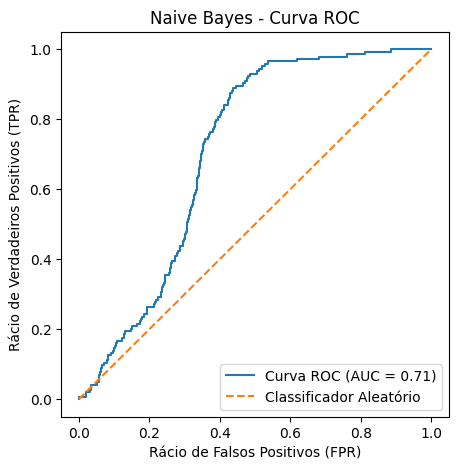

In [ ]:
naive_bayes_auc = plot_roc_curve(naive_bayes, naive_bayes_name)

Ao comparar o classificador *Naive Bayes* com um classificador aleatório, verifica-se que o primeiro é melhor do que o segundo quanto à AUC.

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7199
           1       0.02      0.22      0.04       144

    accuracy                           0.82      7343
   macro avg       0.50      0.52      0.47      7343
weighted avg       0.96      0.82      0.88      7343



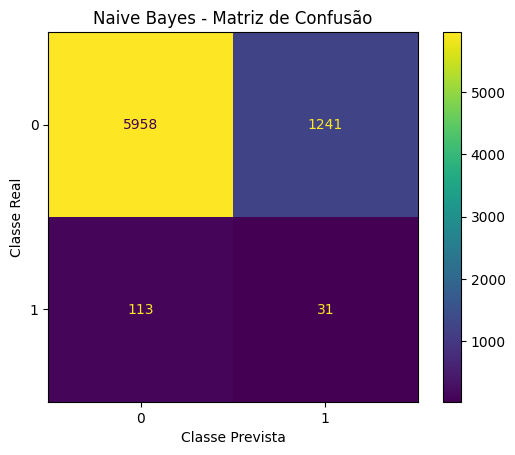

In [ ]:
plot_confusion_matrix(naive_bayes, naive_bayes_name)

Ao observar a matriz de confusão, evidencia-se que houve muitas transações legítimas classificadas pelo algoritmo *Naive Bayes* como fraudulentas, o que não é desejável. Efetivamente, isto resulta numa precisão (para a classe positiva) de 2%, ou seja, o modelo tem uma forte tendência para classificar como fraudulentas transações que são legítimas. Este resultado é extremamente baixo e, a par disso, os valores obtidos para as métricas *recall* (22%) e exatidão (82%) também não são satisfatórios.

#### *Decision Tree*

In [ ]:
decision_tree_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state = 10))
])

decision_tree_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
}

decision_tree_name = 'Decision Tree'

decision_tree = hyperparameter_tuning(decision_tree_pipeline, decision_tree_parameter_grid, decision_tree_name)

Decision Tree - AUC Pré-Afinação: 0.85
Decision Tree - Melhores Parâmetros: {'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__splitter': 'best'}
Decision Tree - AUC Pós-Afinação: 0.82


A *Decision Tree* - antes da afinação de hiper-parâmetros - obtém uma AUC de 0.85. Contudo, depois da afinação de hiper-parâmetros, a AUC nos dados de teste diminui ligeiramente para 0.82. Isto explica-se porque os hiper-parâmetros definidos têm um melhor desempenho no conjunto de treino, em comparação com o conjunto de teste. Esta técnica de modelação executa em menos de 10 segundos.

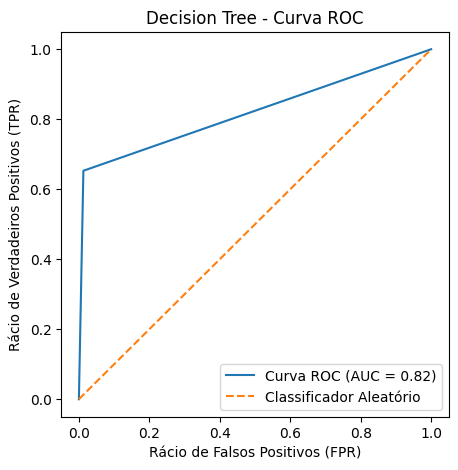

In [ ]:
decision_tree_auc = plot_roc_curve(decision_tree, decision_tree_name)

Efetivamente, observa-se que a *Decision Tree* apresenta um desempenho superior a um classificador aleatório, em termos de AUC.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7199
           1       0.51      0.65      0.57       144

    accuracy                           0.98      7343
   macro avg       0.75      0.82      0.78      7343
weighted avg       0.98      0.98      0.98      7343



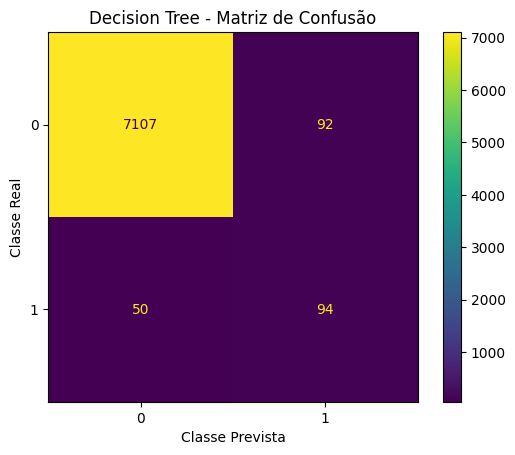

In [ ]:
plot_confusion_matrix(decision_tree, decision_tree_name)

Analisando a matriz de confusão, fica claro que este modelo classificou como fraudulentas quase tantas transações legítimas (92) como realmente fraudulentas (94), o que resulta numa precisão (para a classe positiva) de 51%. Contudo, o elevado número de transações fraudulentas corretamente classificadas pela *Decision Tree* resulta num *recall* de 65% e o desequilíbrio do conjunto de dados faz com que a exatidão seja de 98%. Este desempenho não é mau, mas ainda não é o idealmente pretendido.

#### *Bagging*

In [ ]:
bagging_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(random_state = 10), random_state = 10))
])

bagging_parameter_grid = {
    'classifier__n_estimators': [10, 20, 30],
    'classifier__max_samples': [0.5, 1.0],
    'classifier__max_features': [0.5, 1.0],
}

bagging_name = 'Bagging'

bagging = hyperparameter_tuning(bagging_pipeline, bagging_parameter_grid, bagging_name)

O modelo de *Bagging* - com uma *Decision Tree* como estimador (por ser instável e sensível a pequenas perturbações, logo, apropriado) - apresenta uma AUC de 0.87 antes da afinação de hiper-parâmetros, sendo que esse valor sobe para 0.91 após a afinação. O tempo de execução é de cerca de 1 minuto.

In [ ]:
bagging_auc = plot_roc_curve(bagging, bagging_name)

A curva ROC desta instância do algoritmo de *Bagging* mostra-se consideravelmente melhor do que a de um classificador aleatório.

In [ ]:
plot_confusion_matrix(bagging, bagging_name)

Visualizando a matriz de confusão, destaca-se que este modelo de *Bagging* não classificou como fraudulenta nenhuma transação legítima, o que é um aspeto extremamente positivo, evidenciado pela precisão (para a classe positiva) de 100%. Contudo, algumas transações fraudulentas foram classificadas como legítimas, o que se traduz num *recall* de 71%. A exatidão é de 99%, pelo que, considerando todas estas métricas de avaliação, considera-se este modelo como muito bom.

#### *Random Forest*

In [ ]:
random_forest_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state = 10))
])

random_forest_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_features': ['sqrt', 'log2'],
}

random_forest_name = 'Random Forest'

random_forest = hyperparameter_tuning(random_forest_pipeline, random_forest_parameter_grid, random_forest_name)

O modelo de *Random Forest* - independentemente da afinação de hiper-parâmetros - retorna uma AUC de 0.93, executando em cerca de 1 minuto.

In [ ]:
random_forest_auc = plot_roc_curve(random_forest, random_forest_name)

De facto, a AUC do algoritmo de *Random Forest* é amplamente superior à de um classificador aleatório.

In [ ]:
plot_confusion_matrix(random_forest, random_forest_name)

A matriz de confusão do modelo de *Random Forest* mostra que todas as transações classificadas como fraudulentas são, efetivamente, fraudulentas, pelo que a precisão (para a classe positiva) é de 100%. Ainda assim, houve 43 transações fraudulentas classificadas como legítimas, levando ao valor de *recall* de 70%. A exatidão é de 99%, o que, juntamente com os valores obtidos para as outras métricas, permite considerar este modelo muito bom.

#### *AdaBoost*

In [ ]:
adaboost_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', AdaBoostClassifier(RandomForestClassifier(random_state = 10), random_state = 10))
])

adaboost_parameter_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.1, 0.5, 1.0],
}

adaboost_name = 'AdaBoost'

adaboost = hyperparameter_tuning(adaboost_pipeline, adaboost_parameter_grid, adaboost_name)

O algoritmo *AdaBoost* obtém uma AUC de 0.94, pré-afinação e pós-afinação de hiper-parâmetros, demorando cerca de 2 minutos a executar.

In [ ]:
adaboost_auc = plot_roc_curve(adaboost, adaboost_name)

A AUC desta técnica de modelação *AdaBoost* é notoriamente maior do que a métrica correspondente de um classificador aleatório.

In [ ]:
plot_confusion_matrix(adaboost, adaboost_name)

Considerando a matriz de confusão, salienta-se que o *AdaBoost* acertou em todas as transações fraudulentas prevista, daí ter obtido uma precisão (para a classe positiva) de 100%. No entanto, 42 transações fraudulentas foram previstas como sendo legítimas, o que levou ao *recall* de 71%. Globalmente - vendo também a exatidão de 99% -, o desempenho do modelo pode ser definido como muito positivo.

#### *Gradient Boosting*

In [ ]:
gradient_boosting_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state = 10))
])

gradient_boosting_parameter_grid = {
    'classifier__loss': ['log_loss', 'deviance', 'exponential'],
    'classifier__criterion': ['friedman_mse', 'squared_error'],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

gradient_boosting_name = 'Gradient Boosting'

gradient_boosting = hyperparameter_tuning(gradient_boosting_pipeline, gradient_boosting_parameter_grid, gradient_boosting_name)

Antes da afinação de hiper-parâmetros, o modelo de *Gradient Boosting* retorna uma AUC de 0.96. Todavia, após a afinação de hiper-parâmetros, o valor obtido para a AUC decresce para a 0.95, o que se deverá ao facto de os melhores hiper-parâmetros para o conjunto de treino não coincidirem com os melhores hiper-parâmetros para o conjunto de teste. O tempo de execução encontra-se entre 1 e 2 minutos.

In [ ]:
gradient_boosting_auc = plot_roc_curve(gradient_boosting, gradient_boosting_name)

A AUC deste modelo de *Gradient Boosting* é evidentemente maior do que a de um classificador aleatório.

In [ ]:
plot_confusion_matrix(gradient_boosting, gradient_boosting_name)

A matriz de confusão deste *Gradient Boosting* mostra que existem transações legítimas classificadas como fraudulentas e vice-versa. Assim sendo, os valores de precisão e de *recall* (para a classe positiva), embora elevados, não alcançam os 100%, sendo 94% e 71%, respetivamente. O valor obtido para a exatidão é 99% - ainda que a pouca relevância desta métrica já tenha sido discutida -, pelo que este modelo é bom, mas não ótimo.

#### *Support Vector Machine*

In [ ]:
svm_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability = True, random_state = 10))
])

svm_parameter_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_name = 'Support Vector Machine'

svm = hyperparameter_tuning(svm_pipeline, svm_parameter_grid, svm_name)

Support Vector Machine - AUC Pré-Afinação: 0.89
Support Vector Machine - Melhores Parâmetros: {'classifier__kernel': 'rbf'}
Support Vector Machine - AUC Pós-Afinação: 0.89


Antes e depois da afinação de hiper-parâmetros, a *Support Vector Machine* consegue uma AUC de 0.89, demorando cerca de TODO minutos a executar.

NameError: name 'contextualize' is not defined

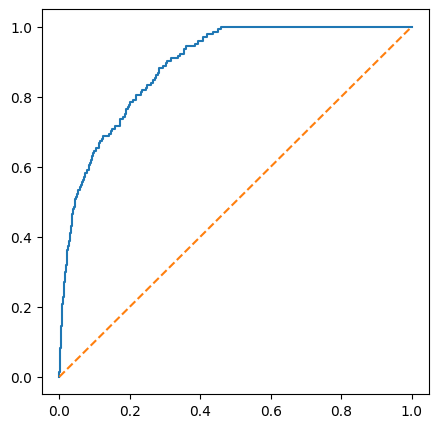

In [ ]:
svm_auc = plot_roc_curve(svm, svm_name)

A curva ROC desta *Support Vector Machine* mostra-se, tal como seria de esperar, bastante melhor do que a de um classificador aleatório.

In [ ]:
plot_confusion_matrix(svm, svm_name)

TODO

#### *Neural Network*

In [ ]:
neural_network_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state = 10))
])

neural_network_parameter_grid = {
    'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
}

neural_network_name = 'Neural Network'

neural_network = hyperparameter_tuning(neural_network_pipeline, neural_network_parameter_grid, neural_network_name)

Neural Network - AUC Pré-Afinação: 0.94
Neural Network - Melhores Parâmetros: {'classifier__activation': 'relu', 'classifier__solver': 'lbfgs'}
Neural Network - AUC Pós-Afinação: 0.94


A *Neural Network* apresenta um resultado de AUC de 0.94, antes e depois da afinação de hiper-parâmetros, tendo um tempo de execução inferior a 10 minutos.

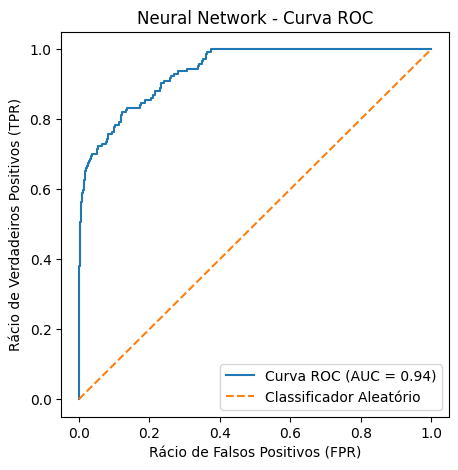

In [ ]:
neural_network_auc = plot_roc_curve(neural_network, neural_network_name)

Ora, a curva ROC da *Neural Network* é substancialmente melhor do que a curva ROC de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7199
           1       0.66      0.53      0.59       144

    accuracy                           0.99      7343
   macro avg       0.82      0.76      0.79      7343
weighted avg       0.98      0.99      0.98      7343



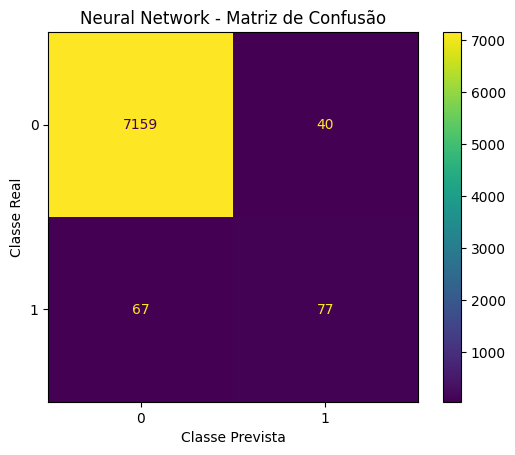

In [ ]:
plot_confusion_matrix(neural_network, neural_network_name)

Interpretando a matriz de confusão associada à *Neural Network*, constata-se que ocorreram alguns erros de falsos positivos (40) - transações legítimas classificadas como fraudulentas - e de falsos negativos (67) - transações fraudulentas classificadas como legítimas -, tal como é visível nas métricas (para a classe positiva) de precisão (66%) e *recall* (53%). Efetivamente, embora a exatidão seja de 99%, os valores obtidos para estas métricas de desempenho não são muito satisfatórios, dado que o modelo ainda comete um número considerável de erros.

#### *Voting*

In [47]:
voting_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', VotingClassifier([('gnb', GaussianNB()), ('dt', DecisionTreeClassifier(random_state = 10)), ('rf', RandomForestClassifier(random_state = 10))], voting = 'soft'))
])

voting_parameter_grid = {
    'classifier__weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [1, 2, 2], [2, 1, 2], [2, 2, 1]],
}

voting_name = 'Voting'

voting = hyperparameter_tuning(voting_pipeline, voting_parameter_grid, voting_name)

Voting - AUC Pré-Afinação: 0.95
Voting - Melhores Parâmetros: {'classifier__weights': [1, 1, 2]}
Voting - AUC Pós-Afinação: 0.95


Pré-afinação e pós-afinação de hiper-parâmetros, este modelo de *Voting* (com os classificadores *Naive Bayes*, *Decision Tree* e *Random Forest*) retorna uma AUC de 0.95, em menos de 1 minuto.

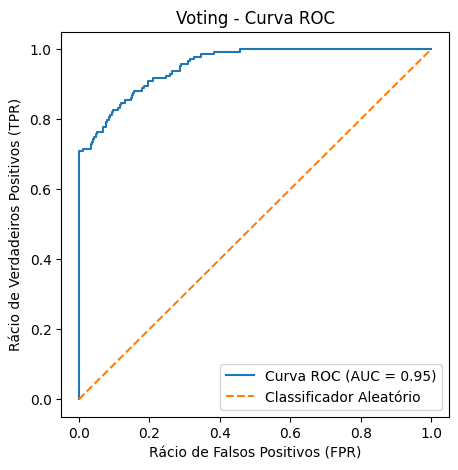

In [ ]:
voting_auc = plot_roc_curve(voting, voting_name)

Em comparação com a curva ROC de um classificador aleatório, esta mesma curva para o modelo de *Voting* demonstra-se muito melhor.

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7199
           1       0.81      0.71      0.76       144

    accuracy                           0.99      7343
   macro avg       0.90      0.85      0.88      7343
weighted avg       0.99      0.99      0.99      7343



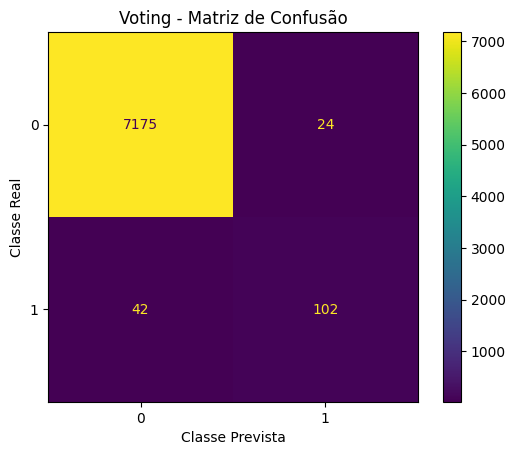

In [49]:
plot_confusion_matrix(voting, voting_name)

Por último, a matriz de confusão do modelo de *Voting* transmite a existência de erros dos dois tipos possíveis (falsos positivos e falsos negativos). Deste modo, 24 transações legítimas classificadas como fraudulentas resultam numa precisão (para a classe positiva) de 81% e 42 transações fraudulentas classificadas como legítimas resultam num *recall* (para a classe positiva) de 71%. Assim, embora estes valores não sejam ótimos, são suficientes para poder considerar este modelo como bom, não desprezando também a exatidão de 99%, ainda que a sua relevância seja quase negligenciável.

### Avaliação dos Modelos

Agora que todos os modelos foram devidamente treinados e testados, é possível resumir os resultados obtidos para cada um deles, no que diz respeito às métricas de avaliação consideradas.

| Modelo | AUC | Precisão | *Recall* | Exatidão |
| ------ | --- | -------- | -------- | -------- |
| ***K-Nearest Neighbors*** | | | | |
| ***Naive Bayes*** | | | | |
| ***Decision Tree*** | | | | |
| ***Bagging*** | | | | |
| ***Random Forest*** | | | | |
| ***AdaBoost*** | | | | |
| ***Gradient Boosting*** | | | | |
| ***Support Vector Machine*** | | | | |
| ***Neural Network*** | | | | |
| ***Voting*** | | | | |

## Avaliação

### Avaliação dos Resultados

In [ ]:
scores = [knn_auc, naive_bayes_auc, decision_tree_auc, bagging_auc, random_forest_auc, adaboost_auc, gradient_boosting_auc, svm_auc, neural_network_auc, voting_auc]
labels = [knn_name, naive_bayes_name, decision_tree_name, bagging_name, random_forest_name, adaboost_name, gradient_boosting_name, svm_name, neural_network_name, voting_name]

plt.figure(figsize = (20, 10))
plt.boxplot(scores, labels = labels)

### Revisão do Processo

### Determinação dos Próximos Passos

## Produção

Tendo treinado, testado e avaliado os modelos, bem como estabelecido a sua ordem de adequação ao problema de mineração de dados a tratar, tendo em conta o desempenho obtido, o modelo considerado final deve ser colocado em produção, isto é, ser submetido na competição do *Kaggle* presente neste *link*: https://www.kaggle.com/competitions/fraud-detection-cc-4036-2425.

Os ficheiros de dados relevantes encontram-se no diretório **kaggle**, sendo os seguintes:
1. **customers.csv:** ficheiro de clientes devidamente tratado, guardado/exportado após o final da *Task 1*
2. **merchants.csv:** ficheiro de comerciantes devidamente tratado, guardado/exportado após o final da *Task 1*
3. **test_transactions.csv:** transações não classificadas, com as quais o modelo será testado na competição do *Kaggle*

Assim, os dados presentes no ficheiro **test_transaction** devem ser devidamente selecionados, limpos, construídos, integrados e formatados, de acordo com o procedimento seguido na *Task 1*, sendo, agora, efetuado através de uma *pipeline*.

In [ ]:
customers = pd.read_csv('kaggle/customers.csv')
merchants = pd.read_csv('kaggle/merchants.csv')
transactions = pd.read_csv('kaggle/test_transactions.csv')

def data_selection(transactions):
    transactions = transactions.drop('trans_date_trans_time', axis = 1)
    return transactions

def data_cleaning(transactions):
    transactions['device_os'] = transactions['device_os'].fillna('unknown')
    transactions = transactions.drop('trans_num', axis = 1)
    return transactions

def data_construction(transactions):
    timestamp = pd.to_datetime(transactions['unix_time'], unit = 's')
    transactions['day'] = timestamp.dt.day
    transactions['month'] = timestamp.dt.month
    transactions['weekday'] = timestamp.dt.weekday

    transactions = transactions.sort_values(by = ['cc_num', 'unix_time'])
    transactions['days_since_last_transaction'] = transactions.groupby('cc_num')['unix_time'].diff()
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'] / (60 * 60 * 24)
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'].fillna(0)

    transactions = transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])
    transactions['merchant_transactions_count'] = transactions.groupby(['cc_num', 'merchant']).cumcount()
    transactions = transactions.drop('unix_time', axis = 1)

    return transactions

def data_integration(transactions, merchants, customers):
    data = transactions.merge(merchants, on = 'merchant').merge(customers, on = 'cc_num')
    data = data.drop(['cc_num', 'merchant'], axis = 1)
    return data

def data_formatting(test_data):
    test_data = pd.get_dummies(test_data, drop_first = False)
    test_data['device_os_Linux'] = False # TODO
    test_data = test_data.sort_index(axis = 1)
    return test_data

test_data = transactions.pipe(data_selection).pipe(data_cleaning).pipe(data_construction).pipe(data_integration, merchants, customers).pipe(data_formatting)

test_data.head()

Finalmente, as transações a testar na competição do *Kaggle* devem ser submetidas ao modelo a colocar em produção, para que seja prevista a probabilidade de cada transação ser fraudulenta ou legítimas, isto é, a probabilidade da variável-alvo *is_fraud*.

In [ ]:
model = bagging
model_name = bagging_name
model_auc = bagging_auc

print(model_name, ' - AUC Pós-Afinação:', model_auc)
model.fit(predictors, targets) # TODO
probabilities = model.predict_proba(test_data)[:, 1]

predictions = pd.DataFrame({
    'index': test_data['index'],
    'is_fraud': probabilities
})

predictions.to_csv('kaggle/predictions.csv', index = False)

O resultado submetido na competição do *Kaggle* encontra-se no ficheiro **predictions.csv**, dentro do diretório **kaggle**.